# Plot the statistics of $\chi_{\perp}$ (read) and $u_{\perp}$ (calc)
See *plot_uchidotn_bothcalc.ipynb*

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
%-------- dir for  
tmStr = '_180d';
grid_dir = [workdir '/MOM6_exp/mom_lowRES/'];  
exp_dir = [workdir '/MOM6_OUT/tr_off_64' tmStr '/'];
chi_dir = [workdir  '/MOM6_OUT/tr_off_64' tmStr '/params/lmddotn_SIGNxmean_ka400_usesol_prog_addreld10/C09/'];
% 
h_dir = [workdir '/MOM6_OUT/forc_uvh_64/sol_h' tmStr '/'];
uvh_dir = [workdir '/MOM6_OUT/forc_uvh_64/uvhm_CS_decomp' tmStr '/'];
tr_dir = [exp_dir 'sols_pt/tr_forcprog_addrel10d_ptrel/'];

dt_flxmean = 6/24;

% ------ time
yr_s = 21;
[day_s, day_e, dt] = deal(1, 730, 1); % 6/24
t_al = day_s:dt:day_e;
nt_al = length(t_al);
fprintf(1,'Will do time = Y%s D%s-D%s.\n',num2str(yr_s), num2str(t_al(1)), num2str(t_al(end)) );

%-------- read model grid
[grid, ~, ~] = read_grid_MOM([grid_dir '']); % SOLUTION/
nk = length(grid.Layer);


Will do time = Y21 D1-D730.


In [3]:
[chin_t,un_t,undir_t] = deal(zeros(grid.nih,grid.njh,nk,nt_al));

for it = 1:nt_al

    [t1, t2] = deal(t_al(it), t_al(it)+dt_flxmean);
    t15 = (t1 + t2)/2;
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s);
    [yrstr15, dystr15, hrstr15] = get_timestr(t15, yr_s); 
    
    %---- read
    chin_fnm = [chi_dir 'K__' yrstr '_' dystr '_' hrstr '.nc'];
    h_fnm = [h_dir 'h_snap__' yrstr '_' dystr '_' hrstr '.nc'];
    flx_fnm = [uvh_dir 'uvh_mean__' yrstr15 '_' dystr15 '_' hrstr15 '.nc'];
    tr_fnm = [tr_dir 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
    ds_chi = ncstruct(chin_fnm);
    ds_h = ncstruct(h_fnm);
    ds_uvh = ncstruct(flx_fnm);
    ds_tr = ncstruct(tr_fnm);
    %
    chidotn = ds_chi.chidotn;
    chin_t(:,:,:,it) = chidotn;
    chidotn = filter_extreme(chidotn,1,99);
    chinfil_t(:,:,:,it) = chidotn;
    
    %--- get u_perp
    for ik = 1:nk
        [uh, vh] = deal(ds_uvh.uh(:,:,ik)./grid.dyCu, ds_uvh.vh(:,:,ik)./grid.dxCv);
        h = ds_h.h(:,:,ik);
        c = ds_tr.tr1(:,:,ik);
        % on p
        [uh_p, vh_p] = uv2p_CG(uh, vh);
        [up, vp] = deal(uh_p./h, vh_p./h);
        
        % 
        [hcx,hcy] = calc_GxGy_CG(c,h,grid.dxCu,grid.dyCu,grid.dxCv,grid.dyCv,0);
        hcx([1 end],:) = 0; hcy(:,[1 end]) = 0;
        [hcx_p,hcy_p] = uv2p_CG(hcx,hcy);
        cgrad_norm = sqrt(hcx_p.^2 + hcy_p.^2);
        [nx, ny] = deal(hcx_p ./ cgrad_norm, hcy_p ./ cgrad_norm); 
        
        % sign
        hcy_xmean = mean(hcy_p,1);
        sign2d = sign( repmat(hcy_xmean, [grid.nih 1]) );
        % sign2d = 1;
        
        % indirect method = (div{Uc}-c*divU)/|delc| [m/s]
        [uc, vc] = calc_TFluxes_CG(uh, vh, c, '2nd_order');
        divuc = calc_div_CG(uc, vc, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT, 1);
        cdivu = c .* calc_div_CG(uh, vh, grid.dyCu,grid.dxCv,grid.dxT,grid.dyT, 1);
        udelc = divuc - cdivu;
        udotn = udelc ./ cgrad_norm ./ sign2d;
        % dir method
        udotn_dir = (up.*nx + vp.*ny) .* sign2d;;
        
        un_t(:,:,ik,it) = udotn;
        undir_t(:,:,ik,it) = udotn_dir;
    end
end

## time smooth $\chi_{\perp}$ and $u_{\perp}$

In [4]:
t_dim = 4;

% slide-mean Chi to eliminate noises
win_dy = 5; % window len in [day] 10
win_hf = (win_dy/dt) / 2; % # of data points in half of the window (even)
chin_t_sld = movmean(chin_t, [win_hf, win_hf], t_dim);
udotn_t_sld = movmean(un_t, [win_hf, win_hf], t_dim);
udotndir_t_sld = movmean(undir_t, [win_hf, win_hf], t_dim);

## get GS core

In [5]:
ds_GS = load('GScore_mom_unsm_wide.mat');
[ii_GS, jj_GS] = deal(ds_GS.ii, ds_GS.jj);
[x_GSC_t, y_GSC_t, id_lat_spdt] = deal(zeros(length(ii_GS),nt_al));

for it = 1:nt_al
    it_ds = find(t_al(it) == ds_GS.t_al);
    id_lat_spdt(:,it) = ds_GS.id_lat_spdt(:,it_ds);
    x_GSC_t(:,it) = ds_GS.x_GSC_t(:,it_ds);
    y_GSC_t(:,it) = ds_GS.y_GSC_t(:,it_ds);
end
x_GSC_m = ds_GS.x_GSC_m;
y_GSC_m = ds_GS.y_GSC_m;

## statistics of $\chi_{\perp}$ and $u_{\perp}$: mean, median, std over time

In [6]:
ik = 1;
dim = 4;
% 
std_chi = std(chinfil_t(:,:,ik,:), 1, dim, 'omitnan');
mean_chi = nanmean(chinfil_t(:,:,ik,:), dim);
% 
std_un = std(udotn_t_sld(:,:,ik,:), 1, dim, 'omitnan');
mean_un = nanmean(udotn_t_sld(:,:,ik,:), dim);

## save data

In [7]:
savefnm = [homedir '/work_MOM/data_for_figure/data_fig9.mat'];
save(savefnm,'t_al','chi_dir','mean_un','std_un','std_chi','mean_chi','grid','x_GSC_m','y_GSC_m');

# plot $\chi_{\perp}$ and $u_{\perp}$ and their meridional profiles

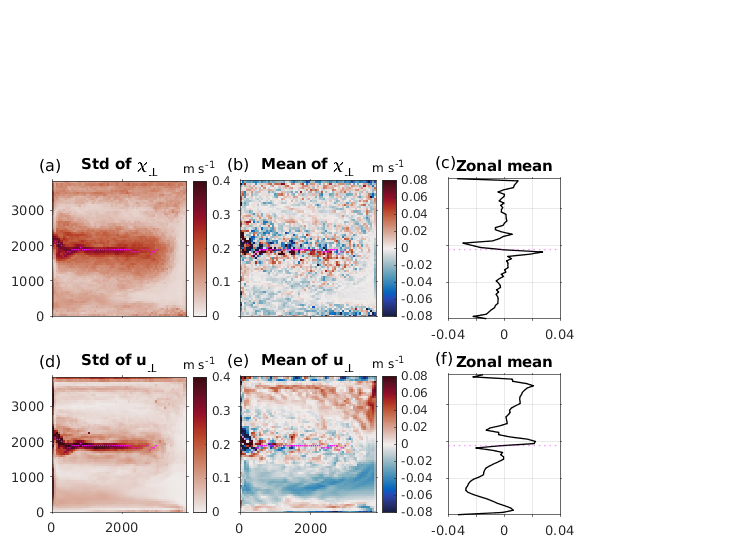

In [8]:

fy_chi = mean(mean_chi,1);
fy_u = mean(mean_un,1); 

% --- chi
[x, y] = deal(grid.lonh, grid.lath);
plt_fields = {std_chi, mean_chi, std_un, mean_un};
ncel = numel(plt_fields);
clim_al = {[0 1]*.4, [-1 1]*8e-2, [0 1]*.4, [-1 1]*8e-2}; 
cmstr_al = {'amp', 'balance', 'amp', 'balance'};
title_al = {'Std of \chi_{\perp}', 'Mean of \chi_{\perp}', 'Std of u_{\perp}', 'Mean of u_{\perp}'};
cbstr_al = {'m s^{-1}', 'm s^{-1}', 'm s^{-1}', 'm s^{-1}'};

% ------ plot
x_bot = 0.07; y_bot = 0.08; h_bot = 0.25; w_bot = h_bot; dx_bot = 0.002; dy_bot = 0.10;
pos_2d = { [x_bot y_bot+h_bot+dy_bot w_bot h_bot], [x_bot+w_bot+dx_bot y_bot+h_bot+dy_bot w_bot h_bot], ...
    [x_bot y_bot w_bot h_bot], [x_bot+w_bot+dx_bot y_bot w_bot h_bot] };

x_r = x_bot+2*w_bot+0.03; y_r = y_bot; h_r = h_bot; w_r = 0.15; dy_r = dy_bot;
pos_yprof = {[x_r y_r+h_r+dy_r w_r h_r] [x_r y_r w_r h_r]};

font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);


sublabels = {'(a)', '(b)', '(d)', '(e)', '(c)', '(f)'};
% ax = ;
for icel = 1:ncel
    ax(icel) = subplot('Position',pos_2d{icel});
    f_do = plt_fields{icel};
    imagescn(x, y, f_do');
    hold on; scatter(x_GSC_m, y_GSC_m, 10, '.m')
    axis square
    
    if icel == 1; set(gca,'xticklabel',''); end
    if icel == 2; set(gca,'xticklabel','','yticklabel',''); end
    if icel == 4; set(gca,'yticklabel',''); end
    
    set(gca,'tickdir','out');
    title(title_al{icel}, 'HorizontAlalignment', 'center');
    caxis(clim_al{icel});
    cmocean(cmstr_al{icel})
    cb = colorbar;
    cb.Title.String = cbstr_al{icel};
    if icel == 2 || icel == 4;
        cb.XTick = clim_al{icel}(1):.02:clim_al{icel}(end);
    end
    hdlb(icel) = subplotlabel(ax(icel),sublabels{icel},'location','northwestoutside','offset',[-0.1 0.05],'fontsize',12);
end

ax(5) = subplot('Position',pos_yprof{1});
plot(fy_chi, y, 'k-', 'linewidth', 1);
ax(5) = gca;
set(gca,'tickdir','out');
ax(5).YTickLabel = '';
ax(5).XGrid = 'on'; ax(5).YGrid = 'on';
ax(5).XLim = [-1 1]*0.04;
ax(5).YLim = y([1 end]);
hold on
hline(mean(y_GSC_m),':m','HandleVisibility','off');
title('Zonal mean')
hdlb(5) = subplotlabel(ax(5),sublabels{5},'location','northwestoutside','offset',[-0.12 .05],'fontsize',12);

% 
ax(6) = subplot('Position',pos_yprof{2});
plot(fy_u, y, 'k-', 'linewidth', 1);
ax(6) = gca;
set(gca,'tickdir','out');
ax(6).YTickLabel = '';
ax(6).XGrid = 'on'; ax(6).YGrid = 'on';
ax(6).XLim = [-1 1]*0.04;
ax(6).YLim = y([1 end]);
hold on
hline(mean(y_GSC_m),':m','HandleVisibility','off');
title('Zonal mean')
hdlb(6) = subplotlabel(ax(6),sublabels{6},'location','northwestoutside','offset',[-0.12 0.05],'fontsize',12);

% ---
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig9'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')